In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# import libraries
from datetime import datetime, timedelta
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from __future__ import division



In [0]:
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objects as go
import plotly.offline as pyoff

In [0]:
#load our data from CSV
tx_data = pd.read_excel(r'/content/drive/My Drive/ADM/Project/rfm/twi_ds.xlsx')


In [0]:
#convert the string date field to datetime
import datetime as dt
tx_data['start_time'] = pd.to_datetime(tx_data['start_time']).dt.date

#we will be using only UK data
tx_us = tx_data.query("country=='United States'").reset_index(drop=True)

taking out missing values


In [0]:
tx_us = tx_us[pd.notnull(tx_us['viewer_id'])]

Taking out negative durations

In [0]:
tx_us = tx_us[(tx_us['duration']>0)]

In [0]:
#create a generic user dataframe to keep viewer id and new segmentation scores
tx_user = pd.DataFrame(tx_data['viewer_id'].unique())
tx_user.columns = ['viewer_id']

#get the max purchase date for each customer and create a dataframe with it
tx_max_purchase = tx_us.groupby('viewer_id').start_time.max().reset_index()
tx_max_purchase.columns = ['viewer_id','MaxViewDate']

#we take our observation point as the max invoice date in our dataset
tx_max_purchase['Recency'] = (tx_max_purchase['MaxViewDate'].max() - tx_max_purchase['MaxViewDate']).dt.days

#merge this dataframe to our new user dataframe
tx_user = pd.merge(tx_user, tx_max_purchase[['viewer_id','Recency']], on='viewer_id')





In [64]:
tx_user.head()


,viewer_id,Recency
0,13047.0,31
1,13748.0,95
2,15100.0,333
3,15291.0,25
4,14688.0,7


In [65]:
#plot a recency histogram

plot_data = [
    go.Histogram(
        x=tx_user['Recency']
    )
]

plot_layout = go.Layout(
        title='Recency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

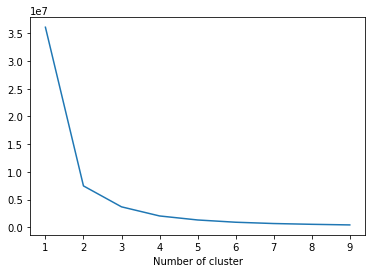

In [66]:
from sklearn.cluster import KMeans

sse={}
tx_recency = tx_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [0]:
#build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

In [68]:
tx_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,491.0,292.234216,40.001685,235.0,260.0,284.0,319.0,371.0
1,555.0,176.798198,30.281036,127.0,151.5,176.0,201.0,234.0
2,945.0,76.428571,20.669602,49.0,60.0,72.0,89.0,126.0
3,1883.0,18.497079,13.374455,0.0,7.0,17.0,29.0,47.0


 3 covers most recent customers whereas 0 has the most inactive ones.

FREQUENCY

In [0]:
#get order counts for each user and create a dataframe with it
tx_frequency = tx_us.groupby('viewer_id').start_time.count().reset_index()
tx_frequency.columns = ['viewer_id','Frequency']

#add this data to our main dataframe
tx_user = pd.merge(tx_user, tx_frequency, on='viewer_id')



In [70]:
#plot the histogram
plot_data = [
    go.Histogram(
        x=tx_user.query('Frequency < 1000')['Frequency']
    )
]

plot_layout = go.Layout(
        title='Frequency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [71]:

#k-means
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

#order the frequency cluster
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

#see details of each cluster
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3429.0,48.594051,43.712814,1.0,15.0,33.0,72.0,185.0
1,419.0,322.720764,129.642777,186.0,221.5,282.0,384.0,756.0
2,23.0,1254.260870,476.314184,799.0,954.5,1106.0,1390.5,2660.0
3,3.0,5647.666667,1848.422661,4569.0,4580.5,4592.0,6187.0,7782.0


ENGAGEMENT

In [72]:

#calculate revenue for each customer
tx_us['Engagement'] = tx_us['duration']
tx_engagement = tx_us.groupby('viewer_id').Engagement.sum().reset_index()

#merge it with our main dataframe
tx_user = pd.merge(tx_user, tx_engagement, on='viewer_id')

#plot the histogram
plot_data = [
    go.Histogram(
        x=tx_user.query('Engagement < 10000')['Engagement']
    )
]

plot_layout = go.Layout(
        title='Engagement'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [73]:
#apply clustering
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Engagement']])
tx_user['EngagementCluster'] = kmeans.predict(tx_user[['Engagement']])


#order the cluster numbers
tx_user = order_cluster('EngagementCluster', 'Engagement',tx_user,True)

#show details of the dataframe
tx_user.groupby('EngagementCluster')['Engagement'].describe()

,count,mean,std,min,25%,50%,75%,max
EngagementCluster,,,,,,,,
0,3672.0,999.569105,1048.375791,3.75,284.2625,601.825,1341.4650,5314.47
1,176.0,9574.363807,4866.050827,5344.92,6158.5350,7804.650,10897.9025,28882.44
2,23.0,51026.210435,15334.865065,31833.68,38523.5500,50491.810,59277.4400,89236.64
3,3.0,207560.196667,46963.820480,168472.50,181511.6450,194550.790,227104.0450,259657.30


Overall Score

In [74]:
#calculate overall score and use mean() to see details
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['EngagementCluster']
tx_user.groupby('OverallScore')['Recency','Frequency','Engagement'].mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,Recency,Frequency,Engagement
OverallScore,,,
0,292.291581,22.885010,352.121930
1,177.428051,32.276867,553.229601
2,77.553473,45.661521,1006.928470
3,22.078591,68.865176,1189.156234
4,14.900000,276.519355,4025.053516
5,10.377193,406.903509,10666.000439
6,7.045455,872.863636,31903.746818
7,3.333333,1243.500000,118746.253333
8,1.666667,5647.666667,43351.156667


In [75]:
tx_user.groupby('OverallScore')['Recency', 'Frequency', 'Engagement'].mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,Recency,Frequency,Engagement
OverallScore,,,
0,292.291581,22.885010,352.121930
1,177.428051,32.276867,553.229601
2,77.553473,45.661521,1006.928470
3,22.078591,68.865176,1189.156234
4,14.900000,276.519355,4025.053516
5,10.377193,406.903509,10666.000439
6,7.045455,872.863636,31903.746818
7,3.333333,1243.500000,118746.253333
8,1.666667,5647.666667,43351.156667


The scoring above clearly shows us that customers with score 8 is our best customers whereas 0 is the worst.

To keep things simple, better we name these scores:
0 to 2: Low Value
3 to 4: Mid Value
5+: High Value
We can easily apply this naming on our dataframe:

In [0]:
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value' 

In [0]:
tx_user_viz=tx_user.query("Engagement < 50000 and Frequency < 2000")
tx_user_vis = pd.DataFrame(tx_user_viz)
tx_user_vis.to_csv(r'/content/drive/My Drive/ADM/Project/rfm/user_rfe_viz.csv')  

In [78]:
tx_user.query("Engagement < 50000 and Frequency < 2000")

,viewer_id,Recency,RecencyCluster,Frequency,FrequencyCluster,Engagement,EngagementCluster,OverallScore,Segment
0,13047.0,31,3,155,0,2870.91,0,3,Mid-Value
1,15291.0,25,3,101,0,4339.50,0,3,Mid-Value
2,13705.0,7,3,18,0,393.72,0,3,Mid-Value
3,17924.0,11,3,29,0,2683.50,0,3,Mid-Value
4,13448.0,16,3,177,0,3095.41,0,3,Mid-Value
...,...,...,...,...,...,...,...,...,...
3855,15098.0,182,1,3,0,39916.50,2,3,Mid-Value
3858,15061.0,3,3,330,1,45126.80,2,6,High-Value
3859,13798.0,1,3,339,1,35587.33,2,6,High-Value
3860,16422.0,17,3,369,1,34684.40,2,6,High-Value


 Let’s see how our segments distributed on a scatter plot:


In [79]:
#Revenue vs Frequency
tx_graph = tx_user.query("Engagement < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Engagement'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Engagement'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'High-Value'")['Engagement'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Engagement"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

#Engagement  Recency

tx_graph = tx_user.query("Engagement  < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Engagement'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Engagement'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['Engagement'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Engagement"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

# Engagement  vs Frequency
tx_graph = tx_user.query("Engagement < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['Frequency'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)


In [98]:
tx_graph[tx_graph['OverallScore']==6].sort_values('Engagement', ascending=False).head(10)

#segmented_rfe[segmented_rfe['RFEScore']=='111'].sort_values('engagement', ascending=False)

SyntaxError: ignored

In [81]:
  tx_graph.head(10)

,viewer_id,Recency,RecencyCluster,Frequency,FrequencyCluster,Engagement,EngagementCluster,OverallScore,Segment
0,13047.0,31,3,155,0,2870.91,0,3,Mid-Value
1,15291.0,25,3,101,0,4339.50,0,3,Mid-Value
2,13705.0,7,3,18,0,393.72,0,3,Mid-Value
3,17924.0,11,3,29,0,2683.50,0,3,Mid-Value
4,13448.0,16,3,177,0,3095.41,0,3,Mid-Value
5,15862.0,8,3,83,0,478.65,0,3,Mid-Value
6,16218.0,29,3,56,0,2613.38,0,3,Mid-Value
7,12838.0,33,3,64,0,292.34,0,3,Mid-Value
8,13255.0,9,3,7,0,173.81,0,3,Mid-Value
9,13758.0,11,3,100,0,2828.10,0,3,Mid-Value
